# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb
import lightgbm as lgb
import os
import seaborn as sns
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import KFold

#### Path management

In [2]:
base: str
if os.getcwd() == "/kaggle/working":
    base = "/kaggle"
else:
    base = os.path.join(os.getcwd())

def get_full_dir(sub_dir: str) -> str:
    return os.path.join(base, sub_dir)

# EDA

In [24]:
df_sample_submission = pd.read_csv(get_full_dir('input/playground-series-s3e14/sample_submission.csv'))
df_train = pd.read_csv(get_full_dir('input/playground-series-s3e14/train.csv'), index_col='id')
df_test = pd.read_csv(get_full_dir('input/playground-series-s3e14/test.csv'), index_col='id')

In [4]:
df_train.isna().sum()

clonesize               0
honeybee                0
bumbles                 0
andrena                 0
osmia                   0
MaxOfUpperTRange        0
MinOfUpperTRange        0
AverageOfUpperTRange    0
MaxOfLowerTRange        0
MinOfLowerTRange        0
AverageOfLowerTRange    0
RainingDays             0
AverageRainingDays      0
fruitset                0
fruitmass               0
seeds                   0
yield                   0
dtype: int64

##### There are no missing values in our train data.

In [5]:
df_sample_submission.head()

,id,yield
0,15289,6025.194
1,15290,6025.194
2,15291,6025.194
3,15292,6025.194
4,15293,6025.194


In [6]:
df_train.head()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
id,,,,,,,,,,,,,,,,,
0,25.0,0.50,0.25,0.75,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.425011,0.417545,32.460887,4476.81146
1,25.0,0.50,0.25,0.50,0.50,69.7,42.1,58.2,50.2,24.3,41.2,24.0,0.39,0.444908,0.422051,33.858317,5548.12201
2,12.5,0.25,0.25,0.63,0.63,86.0,52.0,71.9,62.0,30.0,50.8,24.0,0.39,0.552927,0.470853,38.341781,6869.77760
3,12.5,0.25,0.25,0.63,0.50,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.565976,0.478137,39.467561,6880.77590
4,25.0,0.50,0.25,0.63,0.63,77.4,46.8,64.7,55.8,27.0,45.8,24.0,0.39,0.579677,0.494165,40.484512,7479.93417


In [7]:
df_train.describe()

,clonesize,honeybee,bumbles,andrena,osmia,MaxOfUpperTRange,MinOfUpperTRange,AverageOfUpperTRange,MaxOfLowerTRange,MinOfLowerTRange,AverageOfLowerTRange,RainingDays,AverageRainingDays,fruitset,fruitmass,seeds,yield
count,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000,15289.000000
mean,19.704690,0.389314,0.286768,0.492675,0.592355,82.169887,49.673281,68.656256,59.229538,28.660553,48.568500,18.660865,0.324176,0.502741,0.446553,36.164950,6025.193999
std,6.595211,0.361643,0.059917,0.148115,0.139489,9.146703,5.546405,7.641807,6.610640,3.195367,5.390545,11.657582,0.163905,0.074390,0.037035,4.031087,1337.056850
min,10.000000,0.000000,0.000000,0.000000,0.000000,69.700000,39.000000,58.200000,50.200000,24.300000,41.200000,1.000000,0.060000,0.192732,0.311921,22.079199,1945.530610
25%,12.500000,0.250000,0.250000,0.380000,0.500000,77.400000,46.800000,64.700000,55.800000,27.000000,45.800000,16.000000,0.260000,0.458246,0.419216,33.232449,5128.163510
50%,25.000000,0.500000,0.250000,0.500000,0.630000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,16.000000,0.260000,0.506600,0.446570,36.040675,6117.475900
75%,25.000000,0.500000,0.380000,0.630000,0.750000,86.000000,52.000000,71.900000,62.000000,30.000000,50.800000,24.000000,0.390000,0.560445,0.474134,39.158238,7019.694380
max,40.000000,18.430000,0.585000,0.750000,0.750000,94.600000,57.200000,79.000000,68.200000,33.000000,55.900000,34.000000,0.560000,0.652144,0.535660,46.585105,8969.401840


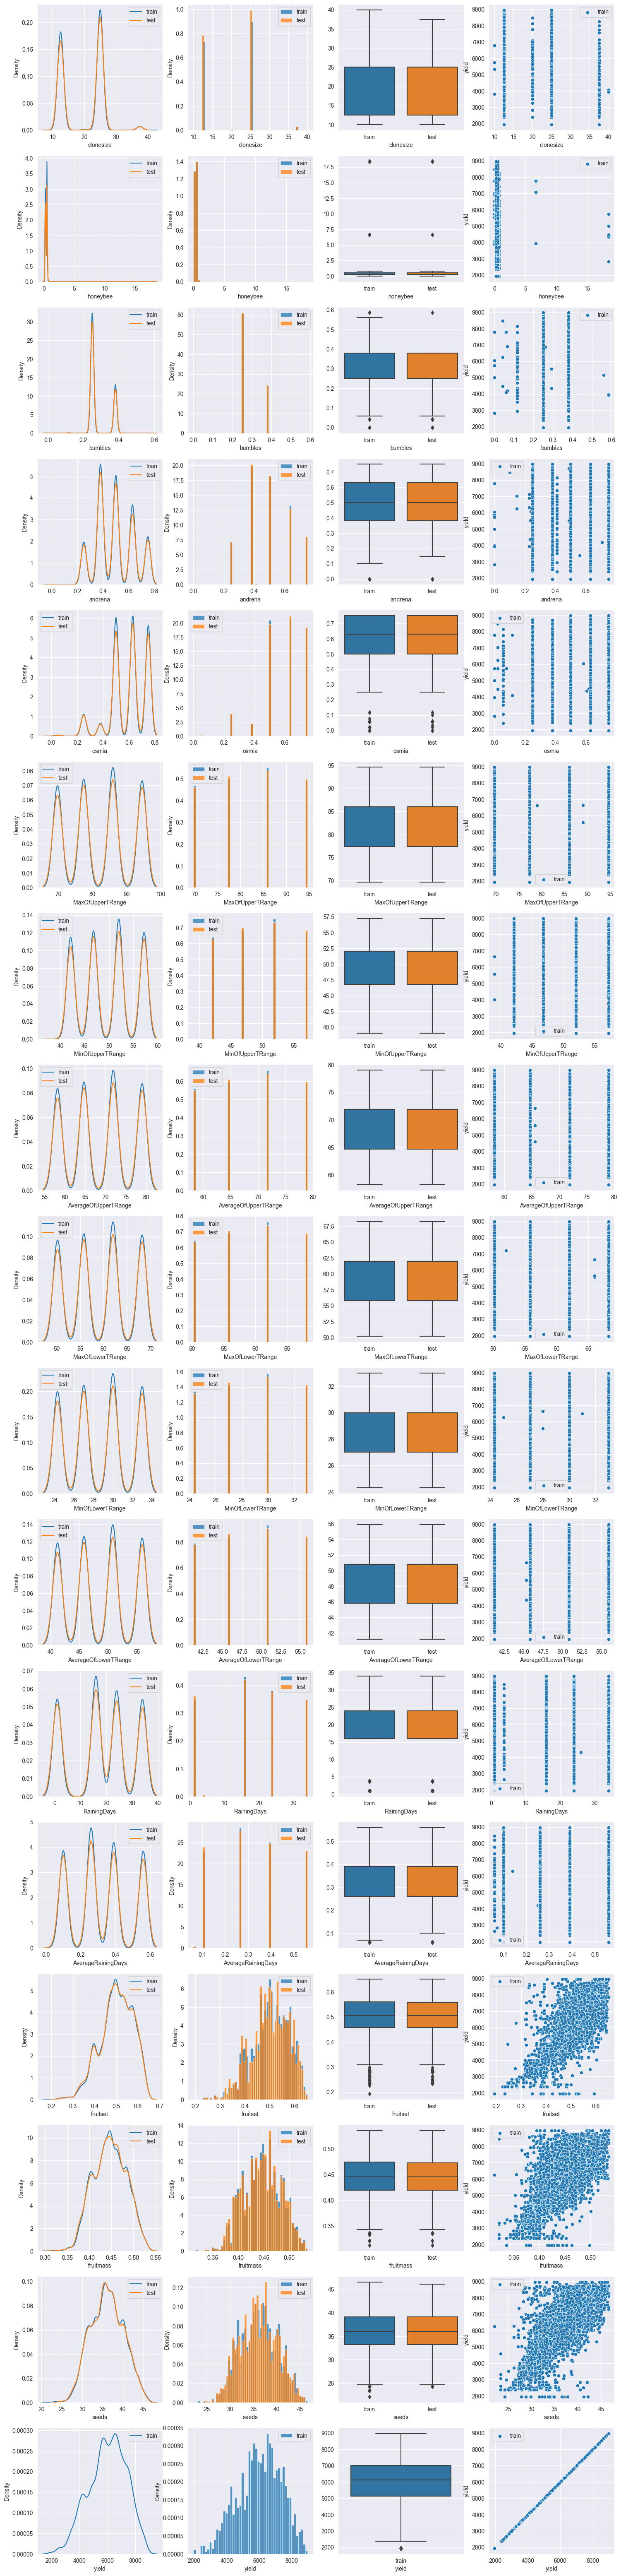

In [25]:
fig, axes = plt.subplots(nrows=len(df_train.select_dtypes(include='number').columns), ncols=4, figsize=(18, 80))
axes = axes.flatten()

i = 0
for col in df_train.select_dtypes(include='number').columns:
    sns.kdeplot(df_train[col], label='train', ax=axes[i], fill=False)
    sns.histplot(df_train[col], label='train', ax=axes[i + 1], stat="density", bins=50)

    if col != 'yield':
        sns.kdeplot(df_test[col], label='test', ax=axes[i], fill=False)
        sns.histplot(df_test[col], label='test', ax=axes[i + 1], stat="density", bins=50)

    if col != 'yield':
        tmp_data = pd.DataFrame({"train": df_train[col], "test": df_test[col]})
        sns.boxplot(data=tmp_data, ax=axes[i + 2])
    else:
        tmp_data = pd.DataFrame({"train": df_train[col]})
        sns.boxplot(data=tmp_data, ax=axes[i + 2])
    axes[i + 2].set_xlabel(col)

    sns.scatterplot(x=col, y="yield", label='train', ax=axes[i + 3], data=df_train)

    axes[i].legend()
    axes[i + 1].legend()
    axes[i + 3].legend()
    i += 4

plt.show()

### The apper to be some true outliers in the honeybee colum around 18 and 6, the mean for that column is ~0.389

In [9]:
def show_honeybee_outlier_count(df: pd.DataFrame):
    honeybee_data = df['honeybee']
    total = honeybee_data.count()
    below_one = honeybee_data[honeybee_data < 1].count()
    above_17 = honeybee_data[honeybee_data > 17].count()
    one_to_17 = honeybee_data[honeybee_data > 1].count() - above_17
    print(f" Total:\t\t {total}")
    print(f" x < 1:\t\t {below_one}")
    print(f" 1 < x < 17: {one_to_17}")
    print(f" 17 < x:\t {above_17}")

print("Train")
show_honeybee_outlier_count(df_train)
print("Test")
show_honeybee_outlier_count(df_test)

Train
 Total:		 15289
 x < 1:		 15281
 1 < x < 17: 3
 17 < x:	 5
Test
 Total:		 10194
 x < 1:		 10188
 1 < x < 17: 2
 17 < x:	 4


##### Although the Train and Test datasets have a relatively small number of outliers (8 and 6, respectively), representing less than 0.1% of the datasets, it may still be beneficial to remove them. While outliers can sometimes be genuine observations, they can also have a significant impact on statistical analysis and machine learning models, leading to biased results and poor predictive performance. (Removing the outliers from the train set has improved both evaluation loss and loss on the public set upon kaggle submission)

# Handle outliers

In [10]:
df_train = df_train[df_train['honeybee'] < 1]
#df_test[df_test['honeybee'] > 1] = df_train['honeybee'].mean()

# Train Models

In [11]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMRegressor

# Load data
X_train = pd.read_csv(get_full_dir('input/playground-series-s3e14/train.csv'), index_col='id')
y_train = X_train.pop('yield')

# Define parameter grid
param_dist = {
    'n_estimators': [500, 1000, 1500],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 5, 7, 9],
    'min_child_weight': [1, 5, 10],
    'subsample': [0.5, 0.7, 0.9],
    'colsample_bytree': [0.5, 0.7, 0.9],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [0, 0.1, 1],
    'num_leaves': [16, 20, 24],
    'objective': ["mae"]
}

# Create LGBMRegressor object
lgbm = LGBMRegressor()

# Create RandomizedSearchCV object
rs = RandomizedSearchCV(lgbm, param_distributions=param_dist, cv=5, n_iter=100, scoring='neg_mean_absolute_error')

# Fit the model on the training data
rs.fit(X_train, y_train)

# Print the best parameters and RMSE score
print("Best parameters:", rs.best_params_)
print("Best MAE score:", -rs.best_score_)

Best parameters: {'subsample': 0.5, 'reg_lambda': 0, 'reg_alpha': 1, 'objective': 'mae', 'num_leaves': 24, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 9, 'learning_rate': 0.05, 'colsample_bytree': 0.9}
Best MAE score: 343.0801744383313


In [12]:
class Pipeline:

    def __init__(self, model='XGB'):
        self.model_type = model
        if model == 'LGB':
            self.model = lgb.LGBMRegressor(
                #num_leaves = 16,
                #max_depth=5,
                #learning_rate = 0.01,
                #n_estimators=1000,
                #objective = "mae",
                **rs.best_params_
            )
        elif model == 'CatBoost':
            self.model = CatBoostRegressor(
                iterations=1000,
                learning_rate=0.01,
                depth=4,
            )
        else:
            self.model = xgb.XGBRegressor(objective = 'reg:absoluteerror',
                                           tree_method = 'gpu_hist',
                                           colsample_bytree = 0.6,
                                           gamma = 0.8,
                                           learning_rate = 0.01,
                                           max_depth = 5,
                                           min_child_weight = 5,
                                           n_estimators = 1000,
                                           subsample = 0.7)

    def fit(self, X, y, X_val, y_val):
        self.model.fit(X, y.ravel(), eval_set=[(X_val, y_val.ravel())], verbose=False)

    def predict(self, X):
        return self.model.predict(X)

    def grid_search(self, X, y, X_eval, y_eval):
       pass

In [13]:
def train(model_type):
    X = df_train.drop(['yield'], axis=1)
    y = df_train['yield']
    SKFs = KFold(n_splits=5, shuffle=True, random_state=1)
    losses = []
    pipelines = []
    for fold, (idx_tr, idx_vl) in enumerate(SKFs.split(X, y)):
        train_dataframe = df_train.iloc[idx_tr]
        dev_dataframe = df_train.iloc[idx_vl]

        # splits data to features and target
        X_train = train_dataframe.drop('yield', axis=1)
        y_train = train_dataframe['yield']
        X_dev = dev_dataframe.drop('yield', axis=1)
        y_dev = dev_dataframe['yield']

        # crates and fits a pipeline
        pipelineMy = Pipeline(model=model_type)
        pipelineMy.fit(X_train, y_train, X_dev, y_dev)

        # evaluates the model
        pipelines.append(pipelineMy)
        loss = mean_absolute_error(y_dev, pipelineMy.predict(X_dev))
        losses.append(loss)
        print(f'Fold {fold} loss: {loss}')
    print(f'Mean loss: {np.array(losses).mean()}')
    return losses, pipelines

In [14]:
lossesLGB, pipelinesLGB = train('LGB')

C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 0 loss: 342.0046111427022


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 1 loss: 342.6611781174806


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 2 loss: 347.5942169187839


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 3 loss: 339.81599773120547


C:\Users\kubaa\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


Fold 4 loss: 341.8701261281062
Mean loss: 342.78922600765566


In [15]:
lossesCB, pipelinesCB = train('CatBoost')

Fold 0 loss: 355.2065904124773
Fold 1 loss: 357.4577460503982
Fold 2 loss: 363.49467248717
Fold 3 loss: 350.754727034955
Fold 4 loss: 353.423319422003
Mean loss: 356.06741108140073


In [16]:
lossesXGB, pipelinesXGB = train('XGB')

Fold 0 loss: 438.2886270400413
Fold 1 loss: 434.9451897459404
Fold 2 loss: 438.32053783815394
Fold 3 loss: 435.08737659417443
Fold 4 loss: 429.39451705011663
Mean loss: 435.2072496536854


# Make Submission

In [17]:
preds = pipelinesLGB[0].predict(df_test)
for i in range(1, len(pipelinesLGB)):
    preds += pipelinesLGB[0].predict(df_test)
preds = preds / 5.0

In [18]:
preds

array([4327.94764623, 5918.64969604, 7196.14859659, ..., 6493.61362123,
       4405.73413846, 7205.15078494])

In [19]:
submission = pd.DataFrame()
submission['yield'] = preds
submission.index += 15289

In [20]:
submission

,yield
15289,4327.947646
15290,5918.649696
15291,7196.148597
15292,4623.509791
15293,3793.472496
...,...
25478,5462.865233
25479,5601.672283
25480,6493.613621
25481,4405.734138


In [21]:
submission.to_csv("submission.csv", index=True, header=True, index_label="id")